In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from scipy.stats import ttest_ind
import numpy as np
from scipy.stats.stats import pearsonr
from IPython.display import display, Markdown, Latex
plt.style.use('ggplot')

from datetime import timedelta
from dateutil.parser import parse
data_path = '/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/'

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_97178/1559749542.py:8: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


# Load and forma mobility data for BC, Washington, Oregon, California 

In [ ]:
mobility_data = pd.DataFrame()
for year in [2020, 2021, 2022]:
    df = pd.read_csv(data_path + f'google_mobility/clean/US_{year}.csv')
    mobility_data = mobility_data.append(df)
    
for year in [2020, 2021, 2022]:
    df = pd.read_csv(data_path + f'google_mobility/clean/CA_{year}.csv')
    mobility_data = mobility_data.append(df)

In [3]:
nw_mobility = mobility_data[mobility_data['state'].isin(['Washington', 'California', 'Oregon', 'British Columbia'])]

In [4]:
nw_mobility = nw_mobility.dropna(subset='county')

In [5]:
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']

In [ ]:
nw_mobility[nw_mobility['state'] == 'British Columbia']['county'].unique()

In [7]:
nw_mobility['date'] = pd.to_datetime(nw_mobility['date'])

In [8]:
nw_mobility['year'] = [x.year for x in nw_mobility['date']]

In [ ]:
nw_mobility.groupby('year')['residential'].describe()

In [10]:
nw_mobility.replace('Sunshine Coast Regional District', "Sunshine Coast", inplace=True)
nw_mobility.replace('Metro Vancouver', "Greater Vancouver", inplace=True)
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']



In [21]:
len(nw_mobility['location'].unique())

152

In [23]:
nw_mobility.replace('Sunshine Coast Regional District', "Sunshine Coast", inplace=True)
nw_mobility.replace('Metro Vancouver', "Greater Vancouver", inplace=True)
nw_mobility['location'] = nw_mobility['county'] + ', ' + nw_mobility['state']


### Load/Clean/Format Heatwave - Control Data

In [30]:
heatwave_control = pd.read_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/heatwave_control_clean_90.csv')

In [31]:
heatwave_control.rename(columns={'datetime': 'date'}, inplace=True)

In [33]:
heatwave_control['control_day'] = [parse(x) for x in heatwave_control['control_day']]
heatwave_control['date'] = [parse(x) for x in heatwave_control['date']]

In [35]:
heatwave_control['diff'] = (heatwave_control['date'] - heatwave_control['control_day'])

Text(0, 0.5, 'Heat and Control Difference')

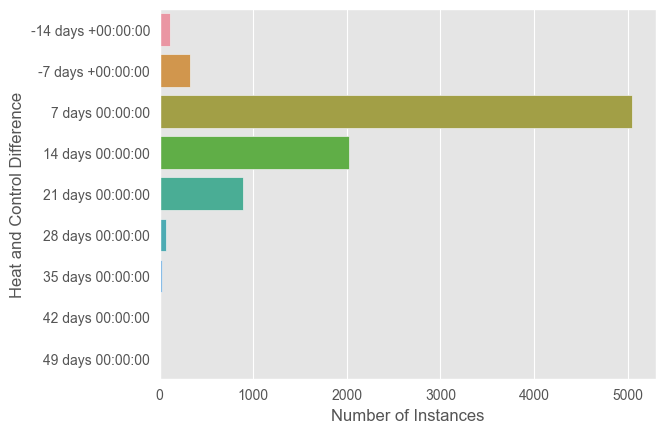

In [ ]:
sns.barplot(temp, y=temp.index, x='Number of Instances')
plt.ylabel("Heat and Control Difference")

In [39]:
us_heatwave_control = heatwave_control[heatwave_control['state'].isin(['California', 'Oregon', 'Washington'])]
us_heatwave_control['county'] = us_heatwave_control['county'] + ' County'
us_heatwave_control['location'] = us_heatwave_control['county'] + ', ' + us_heatwave_control['state']

ca_heatwave_control = heatwave_control[heatwave_control['state'] == 'British Columbia']
ca_heatwave_control['location'] = ca_heatwave_control['county'] + ', ' + ca_heatwave_control['state']

nw_heatwave_control = us_heatwave_control.append(ca_heatwave_control)

/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_97178/937797548.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_heatwave_control['county'] = us_heatwave_control['county'] + ' County'
/var/folders/8g/qp1k_1g91m5f2m9pypxwxdhh0000gn/T/ipykernel_97178/937797548.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_heatwave_control['location'] = us_heatwave_control['county'] + ', ' + us_heatwave_control['state']


In [318]:
nw_heatwave_control.to_csv('/Users/shivyucel/Documents/projects/DPhil/Code_Data/data/heatwave_control/simple_format_heatwave_control_v6_95.csv')

### Merge Mobility with Heat Data

In [45]:
nw_mobility.drop_duplicates(['location', 'date'], inplace=True)

In [46]:
mobility_heat = nw_mobility.merge(nw_heatwave_control[['control_day', 'temperature_2m', 'location', 'date', 'heat_ID']], on=['location', 'date'])

In [47]:
#merge mobility data associated with control dates
mobility_heat = mobility_heat.merge(nw_mobility[['location', 'date', 'retail', 'grocery_pharmacy', 'parks', 'transit', 'workplaces', 'residential']], left_on=['location', 'control_day'], right_on=['location', 'date'], suffixes=['_heat', '_control'])

In [48]:
#calculate differences between heat and control 
mobility_heat['retail_difference'] = mobility_heat['retail_heat'] - mobility_heat['retail_control']
mobility_heat['grocery_pharmacy_difference'] = mobility_heat['grocery_pharmacy_heat'] - mobility_heat['grocery_pharmacy_control']
mobility_heat['parks_difference'] = mobility_heat['parks_heat'] - mobility_heat['parks_control']
mobility_heat['transit_difference'] = mobility_heat['transit_heat'] - mobility_heat['transit_control']
mobility_heat['workplaces_difference'] = mobility_heat['workplaces_heat'] - mobility_heat['workplaces_control']
mobility_heat['residential_difference'] = mobility_heat['residential_heat'] - mobility_heat['residential_control']

In [49]:
mobility_heat['day_of_week'] = [x.day_of_week for x in mobility_heat['date_heat']]
mobility_heat['weekend'] = [1 if x in [5,6] else 0 for x in mobility_heat['day_of_week']]

In [50]:
mobility_heat.reset_index(drop=True,inplace=True)

In [52]:
mobility_heat.to_csv(data_path + 'mobility_heat/mobility_heat_clean_90.csv')